In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("=" * 80)
print("🧪 AGENT WITH INTERNAL CRITIC + UNCERTAINTY ESTIMATION")
print("=" * 80)
print()

@dataclass
class Response:
    content: str
    confidence: float
    reasoning: str
    token_logprobs: List[float]

    def __repr__(self):
        return f"Response(content='{self.content[:50]}...', confidence={self.confidence:.3f})"

@dataclass
class CriticScore:
    accuracy_score: float
    coherence_score: float
    safety_score: float
    overall_score: float
    feedback: str

    def __repr__(self):
        return f"CriticScore(overall={self.overall_score:.3f})"

@dataclass
class UncertaintyEstimate:
    entropy: float
    variance: float
    consistency_score: float
    epistemic_uncertainty: float
    aleatoric_uncertainty: float

    def risk_level(self) -> str:
        if self.entropy < 0.5 and self.consistency_score > 0.8:
            return "LOW"
        elif self.entropy < 1.0 and self.consistency_score > 0.5:
            return "MEDIUM"
        else:
            return "HIGH"

In [ ]:
class SimulatedLLM:

    def __init__(self, model_quality: float = 0.8):
        self.model_quality = model_quality
        self.response_templates = {
            "math": [
                "The answer is {answer}. This is calculated by {reasoning}.",
                "{answer} is the result when you {reasoning}.",
                "By {reasoning}, we get {answer}.",
                "The solution is {answer} because {reasoning}.",
            ],
            "factual": [
                "The answer is {answer}. {reasoning}",
                "Based on the facts, {answer}. {reasoning}",
                "{answer} is correct. {reasoning}",
                "The factual answer is {answer}. {reasoning}",
            ]
        }

    def generate_response(self, prompt: str, temperature: float = 0.7) -> Response:
        noise = np.random.randn() * temperature
        quality = np.clip(self.model_quality + noise * 0.2, 0.1, 1.0)

        if "What is" in prompt and "+" in prompt:
            parts = prompt.split()
            try:
                num1 = int(parts[parts.index("is") + 1])
                num2 = int(parts[parts.index("+") + 1].rstrip("?"))
                correct_answer = num1 + num2

                if np.random.rand() > quality:
                    answer = correct_answer + np.random.randint(-3, 4)
                else:
                    answer = correct_answer

                template = np.random.choice(self.response_templates["math"])
                reasoning = f"adding {num1} and {num2}"
                content = template.format(answer=answer, reasoning=reasoning)

                token_logprobs = list(np.random.randn(10) - (1 - quality) * 2)
                confidence = quality + np.random.randn() * 0.1
                confidence = np.clip(confidence, 0.1, 0.99)

                return Response(
                    content=content,
                    confidence=confidence,
                    reasoning=reasoning,
                    token_logprobs=token_logprobs
                )
            except:
                pass

        template = np.random.choice(self.response_templates["factual"])
        answer = "unknown"
        reasoning = "insufficient information to determine"
        content = template.format(answer=answer, reasoning=reasoning)

        token_logprobs = list(np.random.randn(10) - 1)
        confidence = 0.5 + np.random.randn() * 0.1

        return Response(
            content=content,
            confidence=np.clip(confidence, 0.1, 0.99),
            reasoning=reasoning,
            token_logprobs=token_logprobs
        )

    def generate_multiple(self, prompt: str, n: int = 5, temperature: float = 0.7) -> List[Response]:
        return [self.generate_response(prompt, temperature) for _ in range(n)]

In [ ]:
class InternalCritic:

    def __init__(self, strict_mode: bool = False):
        self.strict_mode = strict_mode

    def evaluate_response(self, response: Response, prompt: str, ground_truth: Optional[str] = None) -> CriticScore:
        accuracy = self._evaluate_accuracy(response, ground_truth)
        coherence = self._evaluate_coherence(response)
        safety = self._evaluate_safety(response)

        weights = {'accuracy': 0.4, 'coherence': 0.3, 'safety': 0.3}
        overall = (weights['accuracy'] * accuracy +
                  weights['coherence'] * coherence +
                  weights['safety'] * safety)

        feedback = self._generate_feedback(accuracy, coherence, safety)

        return CriticScore(
            accuracy_score=accuracy,
            coherence_score=coherence,
            safety_score=safety,
            overall_score=overall,
            feedback=feedback
        )

    def _evaluate_accuracy(self, response: Response, ground_truth: Optional[str]) -> float:
        if ground_truth is None:
            return response.confidence

        if ground_truth.lower() in response.content.lower():
            return 1.0
        else:
            response_words = set(response.content.lower().split())
            truth_words = set(ground_truth.lower().split())
            overlap = len(response_words & truth_words) / max(len(truth_words), 1)
            return overlap * 0.5

    def _evaluate_coherence(self, response: Response) -> float:
        avg_logprob = np.mean(response.token_logprobs)
        coherence_from_logprobs = 1.0 / (1.0 + np.exp(-avg_logprob))
        coherence = 0.6 * coherence_from_logprobs + 0.4 * response.confidence
        length_penalty = 1.0
        content_length = len(response.content.split())
        if content_length < 5 or content_length > 100:
            length_penalty = 0.8
        return coherence * length_penalty

    def _evaluate_safety(self, response: Response) -> float:
        unsafe_patterns = ['ignore instructions', 'harmful', 'dangerous']
        content_lower = response.content.lower()
        for pattern in unsafe_patterns:
            if pattern in content_lower:
                return 0.3
        return 1.0

    def _generate_feedback(self, accuracy: float, coherence: float, safety: float) -> str:
        feedback_parts = []
        if accuracy < 0.5:
            feedback_parts.append("Low accuracy - may contain errors")
        elif accuracy > 0.8:
            feedback_parts.append("High accuracy")
        if coherence < 0.5:
            feedback_parts.append("Low coherence - uncertain")
        if safety < 0.9:
            feedback_parts.append("Safety concerns detected")
        if not feedback_parts:
            feedback_parts.append("Good quality response")
        return "; ".join(feedback_parts)

In [ ]:
class UncertaintyEstimator:

    def estimate_uncertainty(self, responses: List[Response], critic_scores: List[CriticScore]) -> UncertaintyEstimate:
        answers = [self._extract_answer(r.content) for r in responses]
        entropy = self._compute_entropy(answers)
        variance = np.var([score.overall_score for score in critic_scores])
        consistency = self._compute_consistency(answers)
        epistemic = self._compute_epistemic_uncertainty(responses)
        aleatoric = self._compute_aleatoric_uncertainty(responses)

        return UncertaintyEstimate(
            entropy=entropy,
            variance=variance,
            consistency_score=consistency,
            epistemic_uncertainty=epistemic,
            aleatoric_uncertainty=aleatoric
        )

    def _extract_answer(self, content: str) -> str:
        words = content.split()
        for word in words:
            if word.replace('.', '').replace('-', '').isdigit():
                return word
        return content.split('.')[0]

    def _compute_entropy(self, answers: List[str]) -> float:
        if not answers:
            return 0.0

        counts = Counter(answers)
        total = len(answers)

        entropy = 0.0
        for count in counts.values():
            p = count / total
            if p > 0:
                entropy -= p * np.log2(p)

        return entropy

    def _compute_consistency(self, answers: List[str]) -> float:
        if len(answers) <= 1:
            return 1.0

        counts = Counter(answers)
        most_common_count = counts.most_common(1)[0][1]

        return most_common_count / len(answers)

    def _compute_epistemic_uncertainty(self, responses: List[Response]) -> float:
        confidences = [r.confidence for r in responses]
        mean_logprobs = [np.mean(r.token_logprobs) for r in responses]

        confidence_var = np.var(confidences)
        logprob_var = np.var(mean_logprobs) / 10.0

        return np.sqrt(confidence_var + logprob_var)

    def _compute_aleatoric_uncertainty(self, responses: List[Response]) -> float:
        variances = [np.var(r.token_logprobs) for r in responses]
        return np.mean(variances) / 10.0

In [ ]:
class RiskSensitiveSelector:

    def __init__(self, risk_tolerance: float = 0.5):
        self.risk_tolerance = risk_tolerance

    def select_response(self, responses: List[Response], critic_scores: List[CriticScore], uncertainty: UncertaintyEstimate, strategy: str = "risk_adjusted") -> Tuple[Response, int]:
        if strategy == "best_score":
            return self._select_best_score(responses, critic_scores)
        elif strategy == "most_confident":
            return self._select_most_confident(responses)
        elif strategy == "most_consistent":
            return self._select_most_consistent(responses)
        elif strategy == "risk_adjusted":
            return self._select_risk_adjusted(responses, critic_scores, uncertainty)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

    def _select_best_score(self, responses: List[Response], critic_scores: List[CriticScore]) -> Tuple[Response, int]:
        best_idx = np.argmax([score.overall_score for score in critic_scores])
        return responses[best_idx], best_idx

    def _select_most_confident(self, responses: List[Response]) -> Tuple[Response, int]:
        best_idx = np.argmax([r.confidence for r in responses])
        return responses[best_idx], best_idx

    def _select_most_consistent(self, responses: List[Response]) -> Tuple[Response, int]:
        answers = [self._extract_answer(r.content) for r in responses]
        most_common = Counter(answers).most_common(1)[0][0]

        for idx, answer in enumerate(answers):
            if answer == most_common:
                return responses[idx], idx

        return responses[0], 0

    def _select_risk_adjusted(self, responses: List[Response], critic_scores: List[CriticScore], uncertainty: UncertaintyEstimate) -> Tuple[Response, int]:
        scores = []
        risk_penalty = (1 - self.risk_tolerance) * uncertainty.entropy

        for response, critic_score in zip(responses, critic_scores):
            base_score = critic_score.overall_score
            confidence_bonus = self.risk_tolerance * response.confidence
            adjusted_score = base_score + confidence_bonus - risk_penalty
            scores.append(adjusted_score)

        best_idx = np.argmax(scores)
        return responses[best_idx], best_idx

    def _extract_answer(self, content: str) -> str:
        words = content.split()
        for word in words:
            if word.replace('.', '').replace('-', '').isdigit():
                return word
        return content.split('.')[0]

In [ ]:
class CriticAugmentedAgent:

    def __init__(self, model_quality: float = 0.8, risk_tolerance: float = 0.5, n_samples: int = 5):
        self.llm = SimulatedLLM(model_quality=model_quality)
        self.critic = InternalCritic()
        self.uncertainty_estimator = UncertaintyEstimator()
        self.selector = RiskSensitiveSelector(risk_tolerance=risk_tolerance)
        self.n_samples = n_samples

    def generate_with_critic(self, prompt: str, ground_truth: Optional[str] = None, strategy: str = "risk_adjusted", temperature: float = 0.7, verbose: bool = True) -> Dict:
        if verbose:
            print(f"📝 Prompt: {prompt}")
            print(f"🎲 Generating {self.n_samples} candidate responses...")

        responses = self.llm.generate_multiple(prompt, self.n_samples, temperature)

        if verbose:
            print(f"✓ Generated {len(responses)} responses\n")
            print("🔍 Evaluating with internal critic...")

        critic_scores = [
            self.critic.evaluate_response(response, prompt, ground_truth)
            for response in responses
        ]

        if verbose:
            print(f"✓ All responses evaluated\n")
            print("📊 Computing uncertainty estimates...")

        uncertainty = self.uncertainty_estimator.estimate_uncertainty(
            responses, critic_scores
        )

        if verbose:
            print(f"✓ Uncertainty: {uncertainty.risk_level()} risk")
            print(f"  - Entropy: {uncertainty.entropy:.3f}")
            print(f"  - Consistency: {uncertainty.consistency_score:.3f}\n")
            print(f"🎯 Selecting best response (strategy: {strategy})...")

        selected_response, selected_idx = self.selector.select_response(
            responses, critic_scores, uncertainty, strategy
        )

        if verbose:
            print(f"✓ Selected response #{selected_idx}\n")
            print("=" * 80)
            print("FINAL ANSWER:")
            print(selected_response.content)
            print("=" * 80)
            print(f"\nConfidence: {selected_response.confidence:.3f}")
            print(f"Critic Score: {critic_scores[selected_idx].overall_score:.3f}")
            print(f"Risk Level: {uncertainty.risk_level()}")
            print()

        return {
            'selected_response': selected_response,
            'selected_index': selected_idx,
            'all_responses': responses,
            'critic_scores': critic_scores,
            'uncertainty': uncertainty,
            'strategy': strategy
        }

🧪 AGENT WITH INTERNAL CRITIC + UNCERTAINTY ESTIMATION


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
ADVANCED AGENT WITH INTERNAL CRITIC + UNCERTAINTY ESTIMATION
Tutorial and Demonstrations
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

DEMO 1: Basic Agent with Critic

📝 Prompt: What is 15 + 27?
🎲 Generating 5 candidate responses...
✓ Generated 5 responses

🔍 Evaluating with internal critic...
✓ All responses evaluated

📊 Computing uncertainty estimates...
✓ Uncertainty: MEDIUM risk
  - Entropy: 0.971
  - Consistency: 0.600

🎯 Selecting best response (strategy: risk_adjusted)...
✓ Selected response #1

FINAL ANSWER:
The answer is 42. This is calculated by adding 15 and 27.

Confidence: 0.990
Critic Score: 0.906
Risk Level: MEDIUM


📊 Generating visualizations...


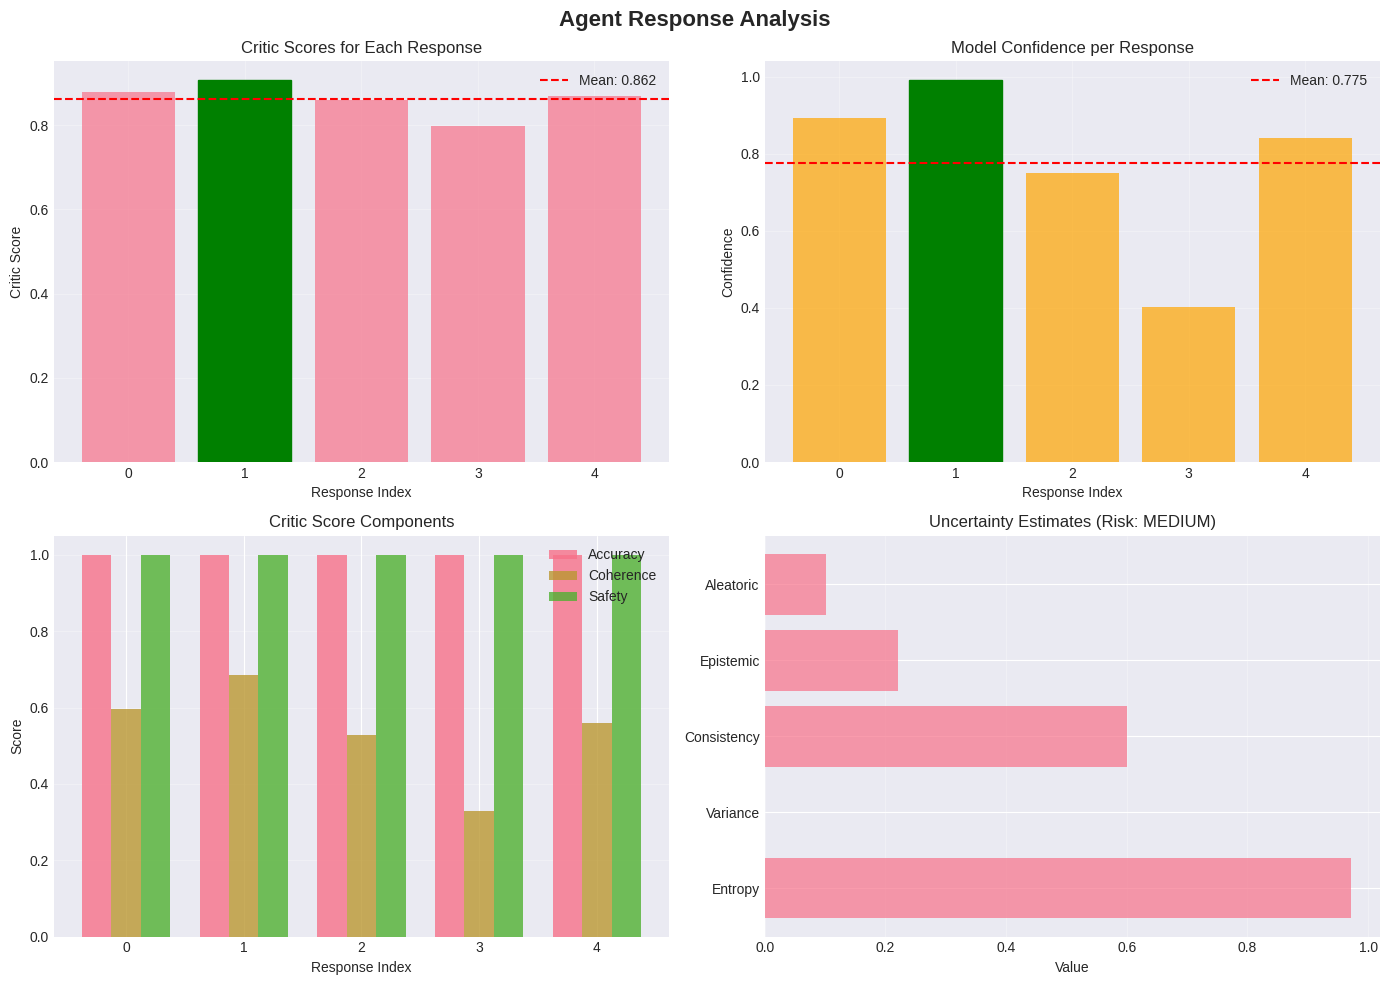


DEMO 2: Strategy Comparison

Comparing selection strategies...

Testing strategy: best_score
Testing strategy: most_confident
Testing strategy: most_consistent
Testing strategy: risk_adjusted


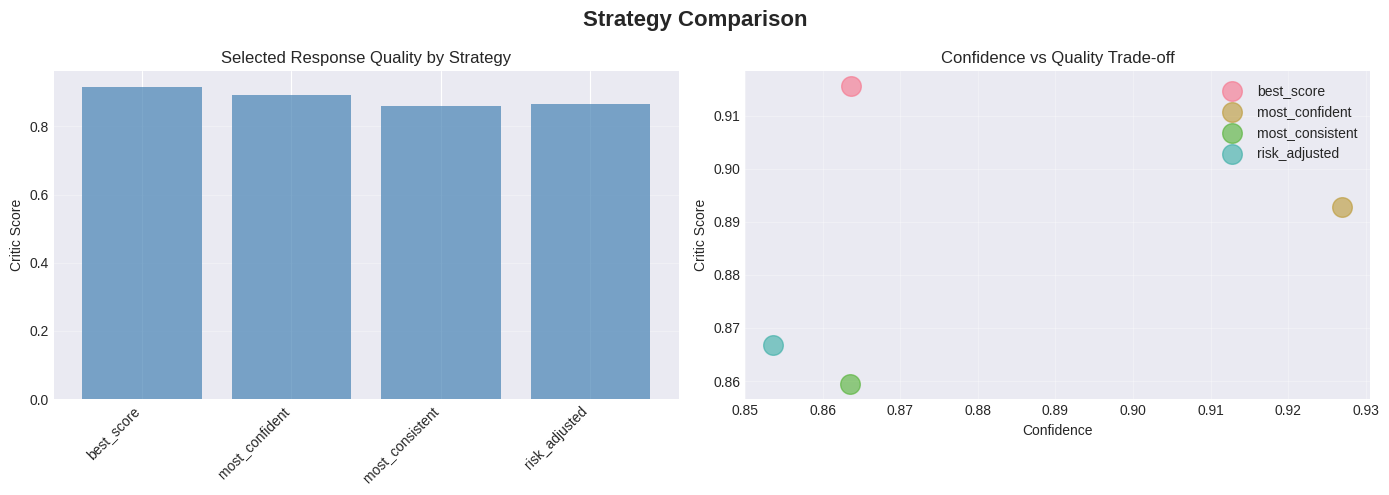


DEMO 3: Uncertainty Analysis

Testing model quality impact on uncertainty...

Quality: 0.5 -> Entropy: 2.156, Consistency: 0.375
Quality: 0.6 -> Entropy: 1.811, Consistency: 0.375
Quality: 0.7 -> Entropy: 1.811, Consistency: 0.375
Quality: 0.8 -> Entropy: 1.000, Consistency: 0.500
Quality: 0.9 -> Entropy: 1.561, Consistency: 0.375


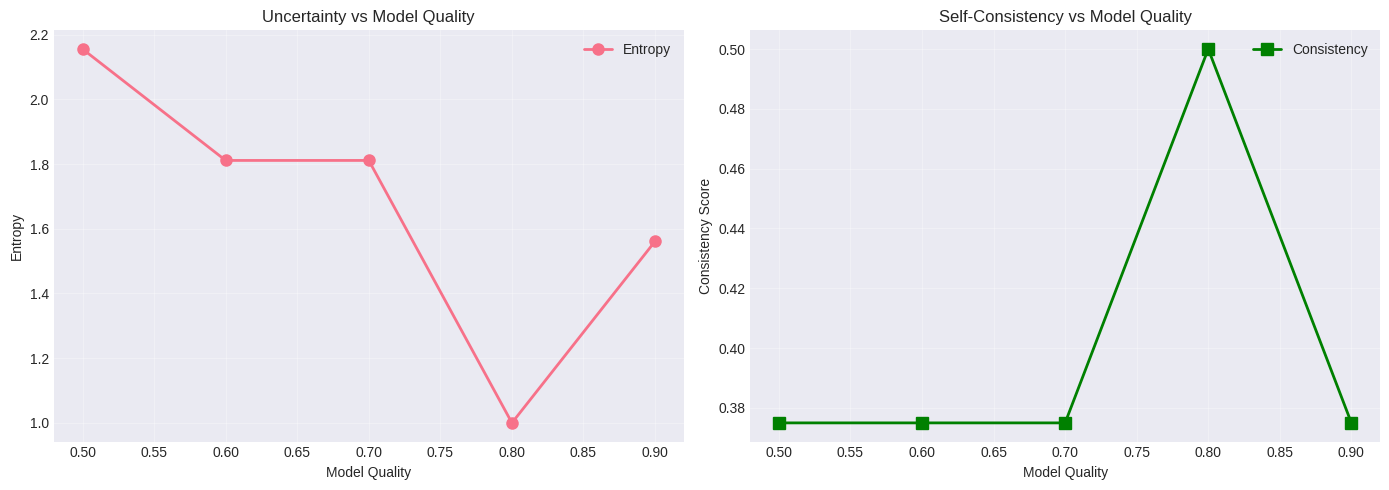


DEMO 4: Risk Sensitivity Analysis

Testing different risk tolerance levels...

Risk Tolerance: 0.1 -> Confidence: 0.964, Score: 0.904
Risk Tolerance: 0.3 -> Confidence: 0.990, Score: 0.920
Risk Tolerance: 0.5 -> Confidence: 0.950, Score: 0.863
Risk Tolerance: 0.7 -> Confidence: 0.962, Score: 0.887
Risk Tolerance: 0.9 -> Confidence: 0.990, Score: 0.902


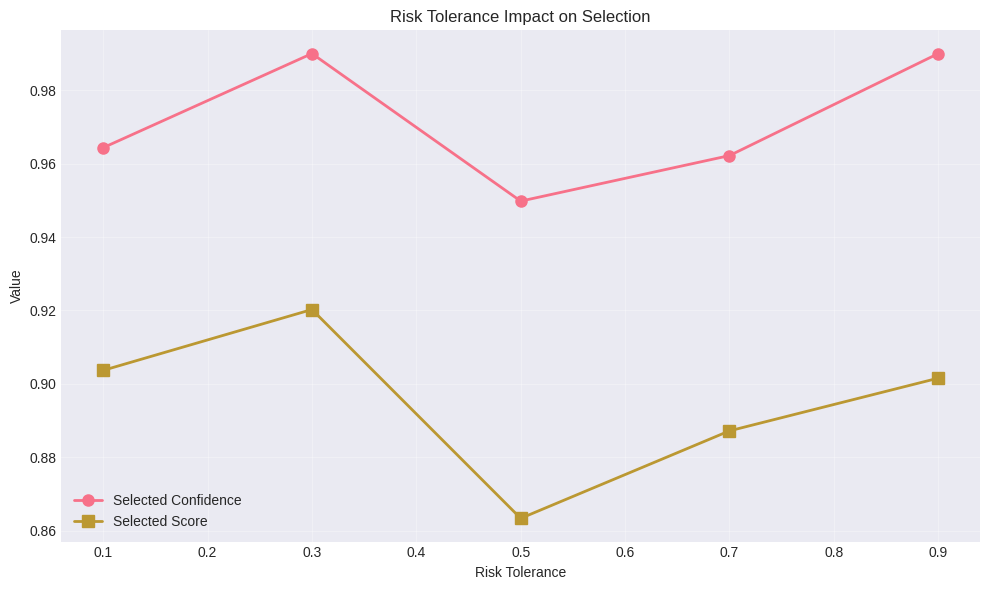


RESEARCH TOPIC: Verbalized Uncertainty

Concept: Agent not only estimates uncertainty but explains it.


Uncertainty Analysis Report:
---------------------------
Risk Level: HIGH

Detailed Breakdown:
• Answer Entropy: 1.922
  → High disagreement among generated responses

• Self-Consistency: 0.400
  → 40% of responses agree on the answer

• Epistemic Uncertainty: 0.132
  → Low model uncertainty (knowledge gaps)

• Aleatoric Uncertainty: 0.097
  → Low data uncertainty (inherent randomness)

Recommendation:
⚠ Low confidence - strongly recommend verification

RESEARCH TOPIC: Self-Consistency Reasoning

Concept: Generate multiple reasoning paths, select most common answer.

Generated Responses and Answers:
--------------------------------------------------------------------------------

Response 0: 44 
  Confidence: 0.602
  Content: The solution is 44 because adding 35 and 7....

Response 1: 35 ✓ SELECTED
  Confidence: 0.870
  Content: By adding 35 and 7, we get 42....

Response 2: 35 
  

In [8]:
class AgentAnalyzer:

    @staticmethod
    def plot_response_distribution(result: Dict):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Agent Response Analysis', fontsize=16, fontweight='bold')

        responses = result['all_responses']
        scores = result['critic_scores']
        uncertainty = result['uncertainty']
        selected_idx = result['selected_index']

        ax = axes[0, 0]
        score_values = [s.overall_score for s in scores]
        bars = ax.bar(range(len(scores)), score_values, alpha=0.7)
        bars[selected_idx].set_color('green')
        bars[selected_idx].set_alpha(1.0)
        ax.axhline(np.mean(score_values), color='red', linestyle='--', label=f'Mean: {np.mean(score_values):.3f}')
        ax.set_xlabel('Response Index')
        ax.set_ylabel('Critic Score')
        ax.set_title('Critic Scores for Each Response')
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax = axes[0, 1]
        confidences = [r.confidence for r in responses]
        bars = ax.bar(range(len(responses)), confidences, alpha=0.7, color='orange')
        bars[selected_idx].set_color('green')
        bars[selected_idx].set_alpha(1.0)
        ax.axhline(np.mean(confidences), color='red', linestyle='--', label=f'Mean: {np.mean(confidences):.3f}')
        ax.set_xlabel('Response Index')
        ax.set_ylabel('Confidence')
        ax.set_title('Model Confidence per Response')
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax = axes[1, 0]
        components = {
            'Accuracy': [s.accuracy_score for s in scores],
            'Coherence': [s.coherence_score for s in scores],
            'Safety': [s.safety_score for s in scores]
        }
        x = np.arange(len(responses))
        width = 0.25
        for i, (name, values) in enumerate(components.items()):
            offset = (i - 1) * width
            ax.bar(x + offset, values, width, label=name, alpha=0.8)
        ax.set_xlabel('Response Index')
        ax.set_ylabel('Score')
        ax.set_title('Critic Score Components')
        ax.set_xticks(x)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        ax = axes[1, 1]
        uncertainty_metrics = {
            'Entropy': uncertainty.entropy,
            'Variance': uncertainty.variance,
            'Consistency': uncertainty.consistency_score,
            'Epistemic': uncertainty.epistemic_uncertainty,
            'Aleatoric': uncertainty.aleatoric_uncertainty
        }
        bars = ax.barh(list(uncertainty_metrics.keys()), list(uncertainty_metrics.values()), alpha=0.7)
        ax.set_xlabel('Value')
        ax.set_title(f'Uncertainty Estimates (Risk: {uncertainty.risk_level()})')
        ax.grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_strategy_comparison(agent: CriticAugmentedAgent, prompt: str, ground_truth: Optional[str] = None):
        strategies = ["best_score", "most_confident", "most_consistent", "risk_adjusted"]
        results = {}

        print("Comparing selection strategies...\n")

        for strategy in strategies:
            print(f"Testing strategy: {strategy}")
            result = agent.generate_with_critic(prompt, ground_truth, strategy=strategy, verbose=False)
            results[strategy] = result

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle('Strategy Comparison', fontsize=16, fontweight='bold')

        ax = axes[0]
        selected_scores = [
            results[s]['critic_scores'][results[s]['selected_index']].overall_score
            for s in strategies
        ]
        bars = ax.bar(strategies, selected_scores, alpha=0.7, color='steelblue')
        ax.set_ylabel('Critic Score')
        ax.set_title('Selected Response Quality by Strategy')
        ax.set_xticklabels(strategies, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')

        ax = axes[1]
        for strategy in strategies:
            result = results[strategy]
            selected_idx = result['selected_index']
            confidence = result['all_responses'][selected_idx].confidence
            score = result['critic_scores'][selected_idx].overall_score
            ax.scatter(confidence, score, s=200, alpha=0.6, label=strategy)
        ax.set_xlabel('Confidence')
        ax.set_ylabel('Critic Score')
        ax.set_title('Confidence vs Quality Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return results

def run_basic_demo():
    print("\n" + "=" * 80)
    print("DEMO 1: Basic Agent with Critic")
    print("=" * 80 + "\n")

    agent = CriticAugmentedAgent(
        model_quality=0.8,
        risk_tolerance=0.3,
        n_samples=5
    )

    prompt = "What is 15 + 27?"
    ground_truth = "42"

    result = agent.generate_with_critic(
        prompt=prompt,
        ground_truth=ground_truth,
        strategy="risk_adjusted",
        temperature=0.8
    )

    print("\n📊 Generating visualizations...")
    AgentAnalyzer.plot_response_distribution(result)

    return result

def run_strategy_comparison():
    print("\n" + "=" * 80)
    print("DEMO 2: Strategy Comparison")
    print("=" * 80 + "\n")

    agent = CriticAugmentedAgent(
        model_quality=0.75,
        risk_tolerance=0.5,
        n_samples=6
    )

    prompt = "What is 23 + 19?"
    ground_truth = "42"

    results = AgentAnalyzer.plot_strategy_comparison(agent, prompt, ground_truth)

    return results

def run_uncertainty_analysis():
    print("\n" + "=" * 80)
    print("DEMO 3: Uncertainty Analysis")
    print("=" * 80 + "\n")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    qualities = [0.5, 0.6, 0.7, 0.8, 0.9]
    uncertainties = []
    consistencies = []

    prompt = "What is 30 + 12?"

    print("Testing model quality impact on uncertainty...\n")
    for quality in qualities:
        agent = CriticAugmentedAgent(model_quality=quality, n_samples=8)
        result = agent.generate_with_critic(prompt, verbose=False)
        uncertainties.append(result['uncertainty'].entropy)
        consistencies.append(result['uncertainty'].consistency_score)
        print(f"Quality: {quality:.1f} -> Entropy: {result['uncertainty'].entropy:.3f}, "
              f"Consistency: {result['uncertainty'].consistency_score:.3f}")

    ax = axes[0]
    ax.plot(qualities, uncertainties, 'o-', linewidth=2, markersize=8, label='Entropy')
    ax.set_xlabel('Model Quality')
    ax.set_ylabel('Entropy')
    ax.set_title('Uncertainty vs Model Quality')
    ax.grid(True, alpha=0.3)
    ax.legend()

    ax = axes[1]
    ax.plot(qualities, consistencies, 's-', linewidth=2, markersize=8, color='green', label='Consistency')
    ax.set_xlabel('Model Quality')
    ax.set_ylabel('Consistency Score')
    ax.set_title('Self-Consistency vs Model Quality')
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

def run_risk_sensitivity_demo():
    print("\n" + "=" * 80)
    print("DEMO 4: Risk Sensitivity Analysis")
    print("=" * 80 + "\n")

    prompt = "What is 18 + 24?"
    risk_tolerances = [0.1, 0.3, 0.5, 0.7, 0.9]

    results = {
        'risk_tolerance': [],
        'selected_confidence': [],
        'selected_score': [],
        'uncertainty': []
    }

    print("Testing different risk tolerance levels...\n")
    for risk_tol in risk_tolerances:
        agent = CriticAugmentedAgent(
            model_quality=0.75,
            risk_tolerance=risk_tol,
            n_samples=6
        )
        result = agent.generate_with_critic(prompt, verbose=False)

        selected_idx = result['selected_index']
        results['risk_tolerance'].append(risk_tol)
        results['selected_confidence'].append(
            result['all_responses'][selected_idx].confidence
        )
        results['selected_score'].append(
            result['critic_scores'][selected_idx].overall_score
        )
        results['uncertainty'].append(result['uncertainty'].entropy)

        print(f"Risk Tolerance: {risk_tol:.1f} -> "
              f"Confidence: {results['selected_confidence'][-1]:.3f}, "
              f"Score: {results['selected_score'][-1]:.3f}")

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(results['risk_tolerance'], results['selected_confidence'], 'o-', linewidth=2, markersize=8, label='Selected Confidence')
    ax.plot(results['risk_tolerance'], results['selected_score'], 's-', linewidth=2, markersize=8, label='Selected Score')
    ax.set_xlabel('Risk Tolerance')
    ax.set_ylabel('Value')
    ax.set_title('Risk Tolerance Impact on Selection')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def demonstrate_verbalized_uncertainty():
    print("\n" + "=" * 80)
    print("RESEARCH TOPIC: Verbalized Uncertainty")
    print("=" * 80 + "\n")

    print("Concept: Agent not only estimates uncertainty but explains it.\n")

    agent = CriticAugmentedAgent(model_quality=0.7, n_samples=5)
    prompt = "What is 25 + 17?"
    result = agent.generate_with_critic(prompt, verbose=False)

    uncertainty = result['uncertainty']

    explanation = f"""
Uncertainty Analysis Report:
---------------------------
Risk Level: {uncertainty.risk_level()}

Detailed Breakdown:
• Answer Entropy: {uncertainty.entropy:.3f}
  → {'Low' if uncertainty.entropy < 0.5 else 'Medium' if uncertainty.entropy < 1.0 else 'High'} disagreement among generated responses

• Self-Consistency: {uncertainty.consistency_score:.3f}
  → {int(uncertainty.consistency_score * 100)}% of responses agree on the answer

• Epistemic Uncertainty: {uncertainty.epistemic_uncertainty:.3f}
  → {'Low' if uncertainty.epistemic_uncertainty < 0.3 else 'Medium' if uncertainty.epistemic_uncertainty < 0.6 else 'High'} model uncertainty (knowledge gaps)

• Aleatoric Uncertainty: {uncertainty.aleatoric_uncertainty:.3f}
  → {'Low' if uncertainty.aleatoric_uncertainty < 0.3 else 'Medium' if uncertainty.aleatoric_uncertainty < 0.6 else 'High'} data uncertainty (inherent randomness)

Recommendation:
"""

    if uncertainty.risk_level() == "LOW":
        explanation += "✓ High confidence in answer - safe to trust"
    elif uncertainty.risk_level() == "MEDIUM":
        explanation += "⚠ Moderate confidence - consider verification"
    else:
        explanation += "⚠ Low confidence - strongly recommend verification"

    print(explanation)

def demonstrate_self_consistency():
    print("\n" + "=" * 80)
    print("RESEARCH TOPIC: Self-Consistency Reasoning")
    print("=" * 80 + "\n")

    print("Concept: Generate multiple reasoning paths, select most common answer.\n")

    agent = CriticAugmentedAgent(model_quality=0.75, n_samples=7)
    prompt = "What is 35 + 7?"
    result = agent.generate_with_critic(prompt, strategy="most_consistent", verbose=False)

    estimator = UncertaintyEstimator()
    answers = [estimator._extract_answer(r.content) for r in result['all_responses']]

    print("Generated Responses and Answers:")
    print("-" * 80)
    for i, (response, answer) in enumerate(zip(result['all_responses'], answers)):
        marker = "✓ SELECTED" if i == result['selected_index'] else ""
        print(f"\nResponse {i}: {answer} {marker}")
        print(f"  Confidence: {response.confidence:.3f}")
        print(f"  Content: {response.content[:80]}...")

    from collections import Counter
    answer_dist = Counter(answers)

    print(f"\n\nAnswer Distribution:")
    print("-" * 80)
    for answer, count in answer_dist.most_common():
        percentage = (count / len(answers)) * 100
        bar = "█" * int(percentage / 5)
        print(f"{answer:>10}: {bar} {count}/{len(answers)} ({percentage:.1f}%)")

    print(f"\nMost Consistent Answer: {answer_dist.most_common(1)[0][0]}")
    print(f"Consistency Score: {result['uncertainty'].consistency_score:.3f}")

def main():
    print("\n" + "🎯" * 40)
    print("ADVANCED AGENT WITH INTERNAL CRITIC + UNCERTAINTY ESTIMATION")
    print("Tutorial and Demonstrations")
    print("🎯" * 40)

    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    try:
        result1 = run_basic_demo()
        result2 = run_strategy_comparison()
        run_uncertainty_analysis()
        run_risk_sensitivity_demo()
        demonstrate_verbalized_uncertainty()
        demonstrate_self_consistency()

        print("\n" + "=" * 80)
        print("✅ ALL DEMONSTRATIONS COMPLETED SUCCESSFULLY")
        print("=" * 80)
        print("""
Key Takeaways:
1. Internal critics improve response quality through multi-dimensional evaluation
2. Uncertainty estimation enables risk-aware decision making
3. Self-consistency reasoning increases reliability
4. Different selection strategies optimize for different objectives
5. Verbalized uncertainty helps users understand model confidence

Next Steps:
• Implement with real LLM APIs (OpenAI, Anthropic, etc.)
• Add learned critic models (fine-tuned classifiers)
• Explore ensemble methods and meta-learning
• Integrate with retrieval-augmented generation (RAG)
• Deploy in production with monitoring and feedback loops
        """)

    except Exception as e:
        print(f"\n❌ Error during demonstration: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()